# Challenge Data ENS 'Optimizing well-being at work'

Lien du challenge https://challengedata.ens.fr/participants/challenges/15/<br>



#### L'objectif du challenge : Prédiction  du confort ressenti au travail par un ensemble d'employés présents dans un grand bâtiment.

### Jeu de données pour la prédiction du confort : <br>
<b>confort objectif :</b> temperature ambiante, humidité, niveau de CO2, luminosité, un indicateur de la qualité de l'air. <br>
<b>confort subjectif :</b> note de confort de 1 à 5 ressenti par les usagers du batiments.<br>

Dans ce challenge 3 dataset (2 training + 1 testing dataset ) sont mis à notre disposition sous format csv.<br>
Pour les données d'apprentissage on a un fichier input de 8000 lignes et un fihier output de 8000 lignes.<br>
Pour les données de test on a un seul fichier input de 2000 lignes, mais contrairement au training dataset le fichier output du testing dataset n'est pas fourni.<br>
<b>Training Dataset : </b> <br>
8000 lignes d'apprentissage. Chaque ligne est caracterisée par :  <br>
ID : entier de 0 à 7999 pour identifier une ligne (observation)<br>
Date : la date où la mesure a été effectué <br>
Temperature : la moyene des temperatures au sein du batiement <br>
Humidity : niveau de l'humidité de l'air au sein du batiment <br>
CO2 : le taux de CO2 en ppm <br>
Humex : un indicateur de la qualité de l'air <br>
Bright : Luminosité <br>
Score : note de confort de 1 à 5  <br>

In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
from sklearn import neighbors, datasets
from collections import Counter

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

# machine learning
from sklearn.model_selection import LeaveOneOut
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

<br>

In [2]:
df_xtr = pd.read_csv("train_input_2yaM34J.csv")# input train
df_ytr = pd.read_csv("train_output_2kCtjpF.csv")# output train
df_xtest = pd.read_csv("test_input_8Vm9H5A.csv")# input test



## Exploration des données

#### Training Input Data

In [3]:
df_xtr.head()


,ID,Date,Temperature,Humidity,Humex,CO2,Bright
0,0,2017-08-31 23:30:00,22.7,56.0,25.7,534.0,1.0
1,1,2017-09-01 00:30:00,22.8,55.0,25.7,506.0,1.0
2,2,2017-09-01 01:30:00,22.9,55.0,25.9,577.0,1.0
3,3,2017-09-01 02:30:00,23.0,55.0,26.1,630.0,1.0
4,4,2017-09-01 03:30:00,23.0,55.0,26.1,643.0,1.0


<b>Pour la prédiction du confort ressenti on se limitera à l'analyse des 5 attributs suivants : <br>
'Temperature','Humidity','Humex','CO2','Bright'.  </b>

#### Training Output Data

In [4]:
df_ytr.head()

,ID,Score
0,0,4.0
1,1,4.0
2,2,4.0
3,3,2.0
4,4,3.0


#### Testing Input Data

In [8]:
df_xtest.head()

,ID,Date,Temperature,Humidity,Humex,CO2,Bright
0,8000,2018-02-18 20:00:00,20.1,26.0,17.9,377.0,1.0
1,8001,2018-02-18 20:30:00,20.2,26.0,18.0,374.0,1.0
2,8002,2018-02-18 21:00:00,20.1,26.0,17.9,379.0,1.0
3,8003,2018-02-18 21:30:00,20.1,26.0,17.9,380.0,1.0
4,8004,2018-02-18 22:00:00,20.0,26.0,17.8,379.0,1.0


In [76]:
result = pd.concat([df_xtr, df_ytr], axis=1, sort=False).reset_index(drop=True)# concatenation input train avec output train
result = result.iloc[:,~result.columns.duplicated()]

In [77]:
result.head()

,ID,Date,Temperature,Humidity,Humex,CO2,Bright,Score
0,0,2017-08-31 23:30:00,22.7,56.0,25.7,534.0,1.0,4.0
1,1,2017-09-01 00:30:00,22.8,55.0,25.7,506.0,1.0,4.0
2,2,2017-09-01 01:30:00,22.9,55.0,25.9,577.0,1.0,4.0
3,3,2017-09-01 02:30:00,23.0,55.0,26.1,630.0,1.0,2.0
4,4,2017-09-01 03:30:00,23.0,55.0,26.1,643.0,1.0,3.0


In [78]:
result.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 8 columns):
ID             8000 non-null int64
Date           8000 non-null object
Temperature    8000 non-null float64
Humidity       8000 non-null float64
Humex          8000 non-null float64
CO2            8000 non-null float64
Bright         8000 non-null float64
Score          8000 non-null float64
dtypes: float64(6), int64(1), object(1)
memory usage: 500.1+ KB


<b>Comme premiere information du training dataset, toutes les lignes sont remplies, il n y a pas de valeurs null<b> <br><br><br><hr>

In [79]:
result.describe()

,ID,Temperature,Humidity,Humex,CO2,Bright,Score
count,8000.00000,8000.00000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,3999.50000,22.94535,33.790750,22.668763,586.471000,41.596375,2.930125
std,2309.54541,1.62307,8.241068,2.578996,202.641522,76.855898,0.893780
min,0.00000,17.90000,16.000000,15.500000,361.000000,1.000000,1.000000
25%,1999.75000,22.10000,27.000000,21.100000,452.000000,1.000000,2.000000
50%,3999.50000,23.20000,33.000000,22.800000,493.000000,1.000000,3.000000
75%,5999.25000,24.10000,41.000000,24.300000,693.250000,58.000000,4.000000
max,7999.00000,28.30000,58.000000,32.100000,2168.000000,882.000000,5.000000


à partir de ce tableau on peut extraire des mesures statistiques des variables quantitatives du dataset.


Les valeurs minimales et maximales peuvent nous donner une idée sur l'intervalle des valeurs, et sont aussi utiles pour détecter les valeurs aberrantes.

La moyenne et l'écart type : La moyenne nous montre la tendance centrale de la distribution, tandis que l'écart-type quantifie son degré de variation.


Count: Nous donne une première idée du volume de données manquantes <br><br><hr>

### Recherche des données manquantes dans le dataset

In [80]:
"""
Fonction qui recherche des données qui n'appartiennent pas au type de variable du dataset ou des données manquantes
dans la dataset
"""
def find_missing_data(data):
    Total = data.isnull().sum().sort_values(ascending = False)
    Percentage = (data.isnull().sum()/data.isnull().count()).sort_values(ascending = False)
    
    return pd.concat([Total,Percentage] , axis = 1 , keys = ['Total' , 'Percent'])

In [12]:
find_missing_data(result)

,Total,Percent
Score,0,0.0
Bright,0,0.0
CO2,0,0.0
Humex,0,0.0
Humidity,0,0.0
Temperature,0,0.0
Date,0,0.0
ID,0,0.0


<b> Obsérvations : </b> <br>
Pas de surprise dans le dataset, toutes les valeurs correspondent au type de variable dans le dataset. <br>




### Détection des valeurs abérrantes du dataset 

In [6]:
def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | 
                              (df[col] > Q3 + outlier_step )].index
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
   
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)  

    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    return multiple_outliers 


In [81]:

Outliers_to_drop = detect_outliers(result,2,["Temperature","Humidity","Humex","Bright","CO2"])
result.loc[Outliers_to_drop]

,ID,Date,Temperature,Humidity,Humex,CO2,Bright,Score
169,169,2017-09-07 21:30:00,28.1,45.0,32.1,1092.0,1.0,1.0
170,170,2017-09-07 22:00:00,27.8,44.0,31.4,1145.0,1.0,1.0
171,171,2017-09-07 22:30:00,27.2,44.0,30.5,1224.0,1.0,2.0
1193,1193,2017-09-29 12:30:00,27.3,40.0,29.8,1092.0,138.0,2.0


<b> Obsérvations : </b> <br>
4 lignes qui possendent plus de 2 valeurs aberantes dans le dataset <br>
Ces valeurs representent une observation légitime qui fait naturellement partie des attributs qu'on étudie. <br>
il est bien connu qu'un taux de CO2 qui dépasse les 1000ppm provoque des somnolences et un manque d'air <br> 
<b> Décision : </b> <br>
Pas de Suppréssion des 4 lignes.
<br>
 <br>



In [56]:
#result = result.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

# Analyse des données numériques

## Etude uni-variée 

In [13]:
sns.set(style="ticks", color_codes=True)

### L'attribut 'Score' (confort subjectif)

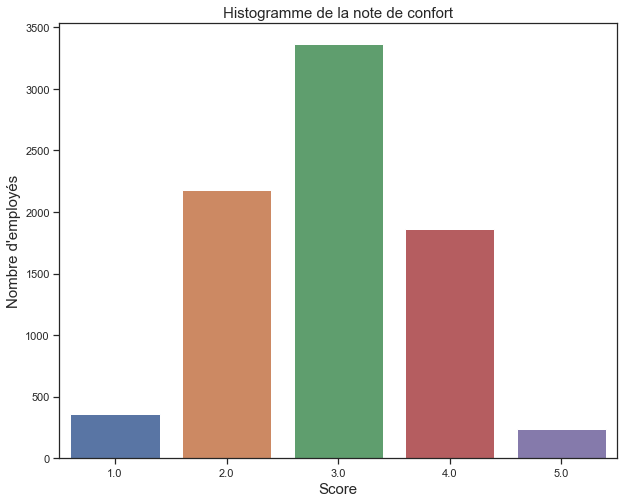

In [14]:

plt.figure(figsize=(10,8))
sns.countplot(x = "Score", data = df_ytr)
plt.ylabel('Nombre d\'employés',fontsize=15)
plt.xlabel('Score',fontsize=15)
plt.title("Histogramme de la note de confort",fontsize=15)
plt.show()

<b>Observations :</b> <br>
L'attribut Score suit une distribution gaussienne de moyenne 3 et d'ecart type qui vaut 1.<br>
Sur 8000 employés on a :<br>
358 ont noté le confort ressenti à 1 <br>
2181 ont noté le confort ressenti à 2 <br>
3362 ont noté le confort ressenti à 3 <br>
1860 ont noté le confort ressenti à 4 <br>
239 ont noté le confort ressenti à 5 <br>


# Etude de la correlation entre le confort objectif et le confort subjectf

## Etude bi-variée

### Matrice de corrélation

(6.5, -0.5)

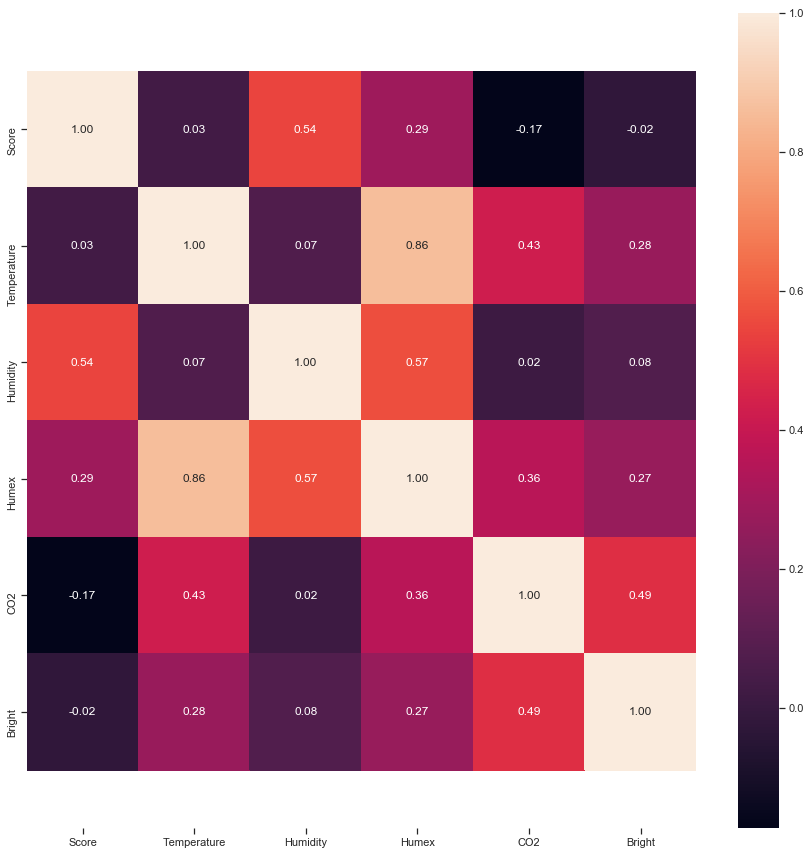

In [15]:
corr_matrix = result[["Score","Temperature","Humidity","Humex","CO2","Bright"]].corr()
fig, ax = plt.subplots(figsize=(15, 15))
ax = sns.heatmap(corr_matrix,
                annot=True,
                fmt = ".2f" )

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

<b>Observations :</b> <br>
L'attribut 'Humidity' a une corrélation lineaire positive de 0.54 avec l'attribut 'Score' (confort subjectif)<br>
L'attribut 'Humex' a une corrélation lineaire positive de 0.29 avec l'attribut 'Score' (confort subjectif)<br>
<b>Décisions :</b> <br>
On doit prendre en considération les attributs 'Humidity' dans l'apprentissage de notre model <br> <br>


## Nuage des points des attributs par rapport aux 5 classes

### Attribut humidité

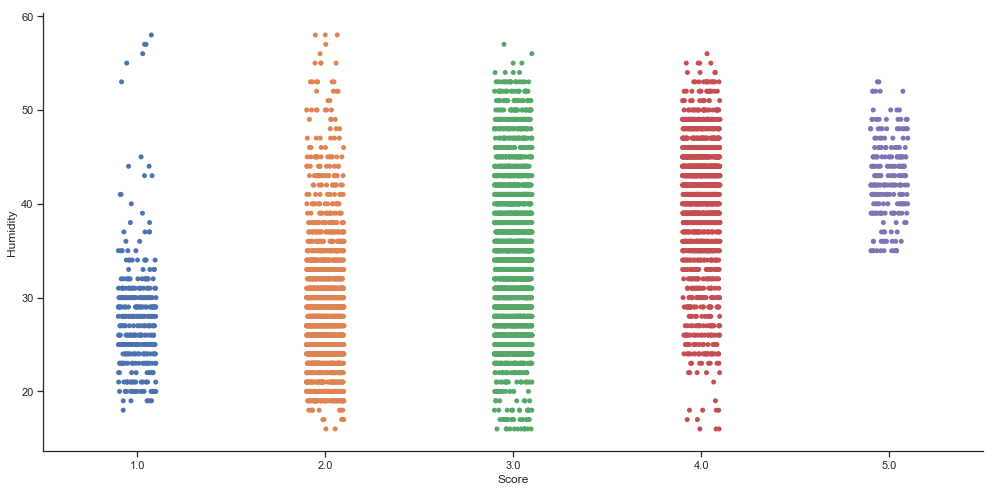

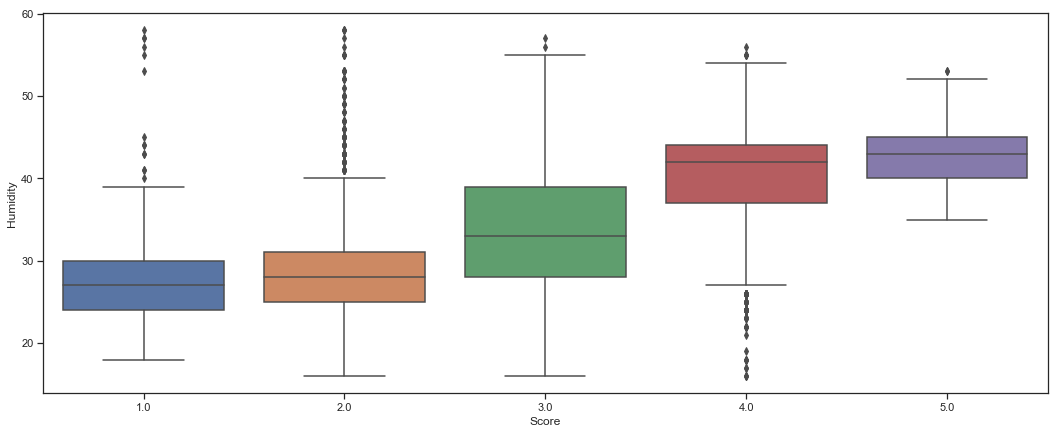

In [16]:
sns.catplot(x="Score", y="Humidity", data=result,height=7,aspect=2)
plt.figure(figsize=(18,7))
sns.boxplot(x="Score", y="Humidity", data=result)


<b>Observations :</b> <br>
Le taux d'humidité optimal est entre [35 53] <br>
<b>Décisions :</b> <br>
On doit prendre en considération l'attribut 'Humidity' dans l'apprentissage de notre model <br> <br>


### Attribut humex qui caractérise la qualité de l'air

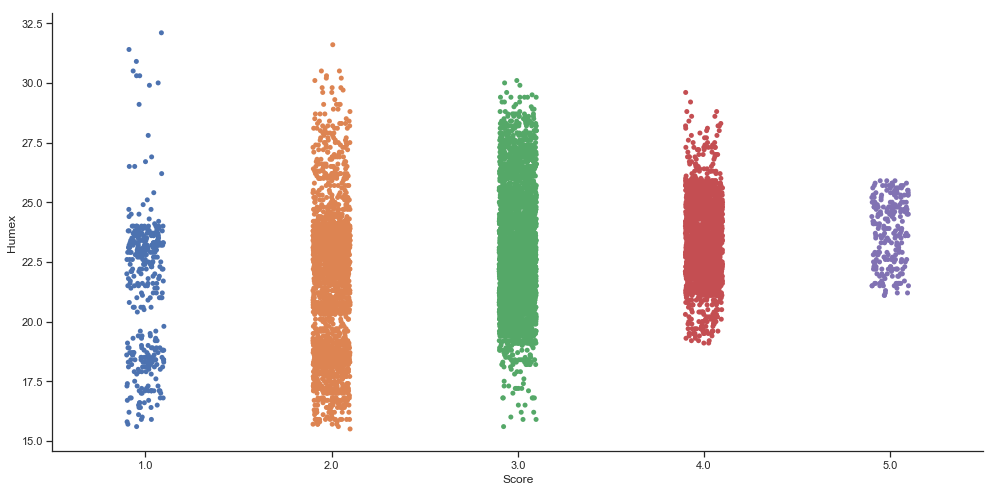

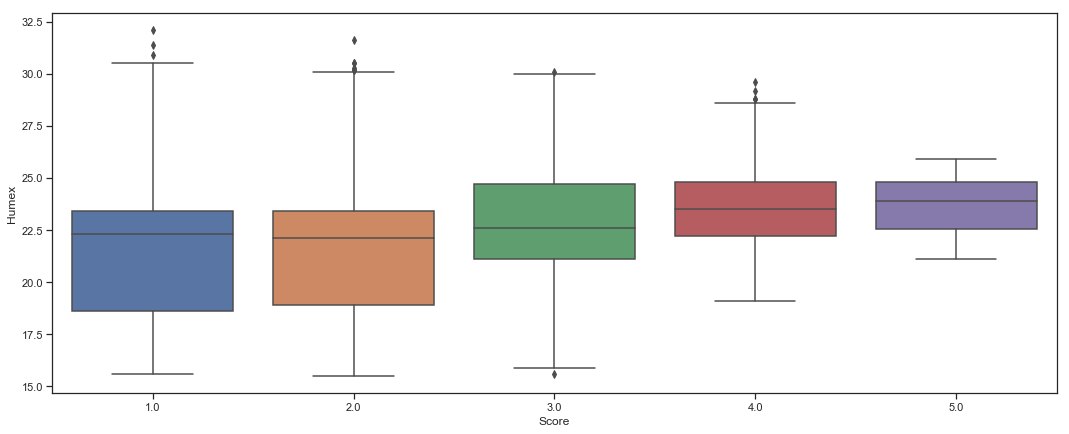

In [17]:
sns.catplot(x="Score", y="Humex", data=result,height=7,aspect=2)
plt.figure(figsize=(18,7))
sns.boxplot(x="Score", y="Humex", data=result)


<b>Observations :</b> <br>
La répartition des valeurs de l'attribut Humex varie d'une classe à une autre <br>
<b>Décisions :</b> <br>
On doit prendre en considération l'attribut 'Humex' dans l'apprentissage de notre model <br> <br>


<br>
### Attribut Température

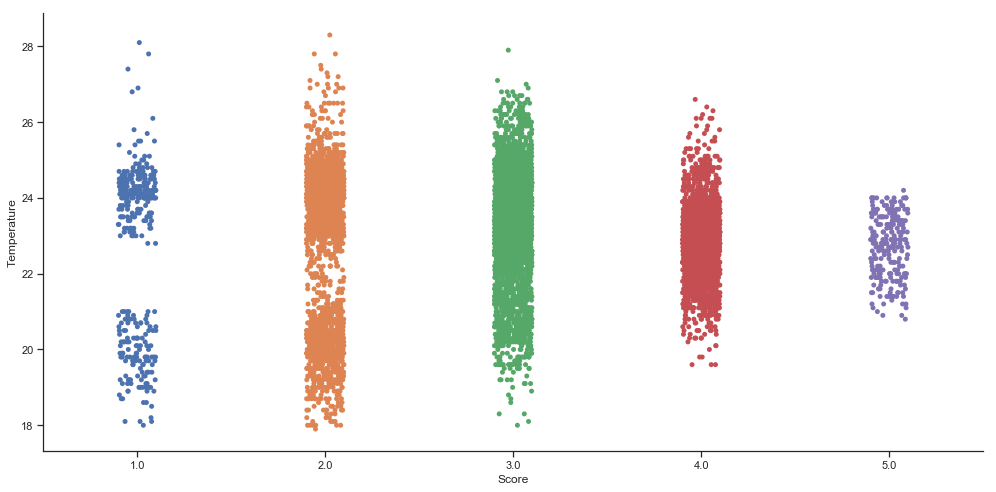

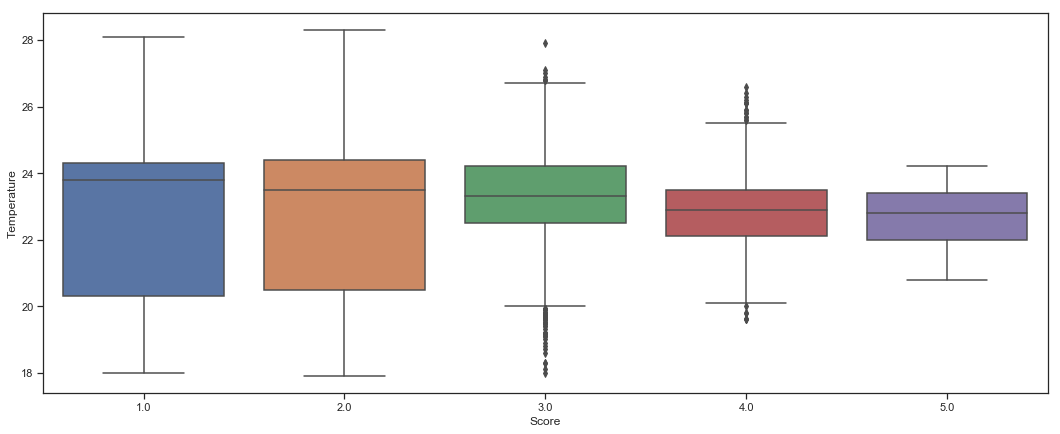

In [18]:
#sns.catplot(x="Score", y="Temperature", data=result)
sns.catplot(x="Score", y="Temperature", data=result,height=7,aspect=2)
plt.figure(figsize=(18,7))
sns.boxplot(x="Score", y="Temperature", data=result)

<b>Observations :</b> <br>
Pour la classe de confort 'Score = 5' la température varie de 20.8 à 24.2 <br>
Pour la classe de confort 'Score = 4' la température varie de 19.6 à 26.6 <br>
Pour la classe de confort 'Score = 3' la température varie de 18 à 27.9 <br>
Pour la classe de confort 'Score = 2' la température varie de 17.9 à 28.3 <br>
Pour la classe de confort 'Score = 1' la température se situe dans l'intervalle $[ 18\ 21]\cup[ 23\ 28.1]$  <br>
Les plages de valeurs varient d'une classe à une autre. <br>
<b>Décisions :</b> <br>
On doit prendre en considération l'attribut 'Temperature' dans l'apprentissage de notre model <br> <br>


### Attribut taux de CO2

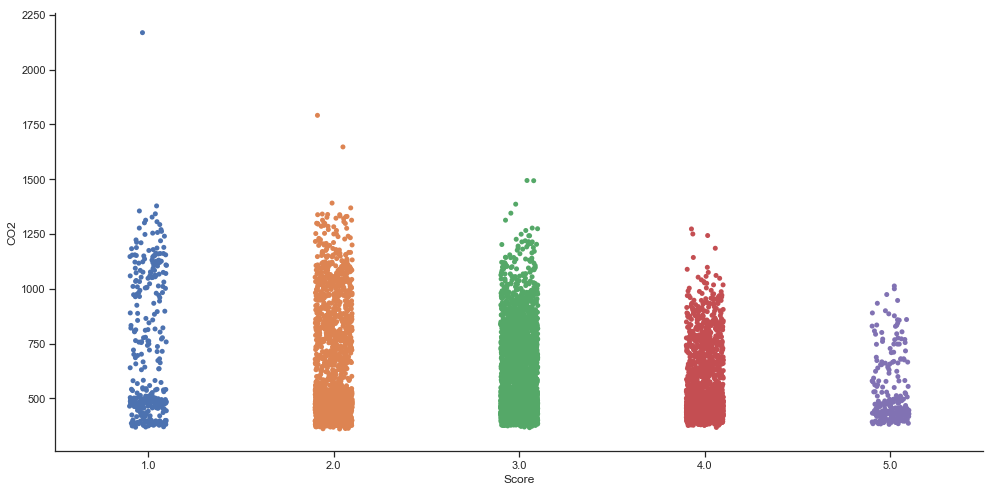

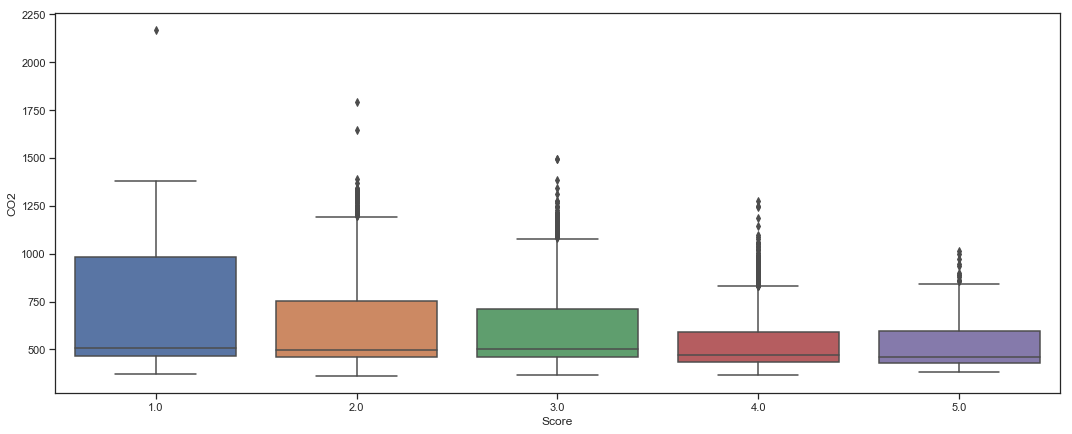

In [19]:
#sns.catplot(x="Score", y="CO2", data=result)
sns.catplot(x="Score", y="CO2", data=result,height=7,aspect=2)
plt.figure(figsize=(18,7))
sns.boxplot(x="Score", y="CO2", data=result)

<b>Observations :</b> <br>
Chaque classe de confort posséde une valeur minimale et une valeur maximale de taux de CO2 propre à elle. <br>
Plus on restreint le taux de CO2 maximal et plus on améliore le confort ressenti. <br>
<b>Décisions :</b> <br>
On doit prendre en considération l'attribut 'CO2' dans l'apprentissage de notre model <br> <br>


#### Attribut Bright

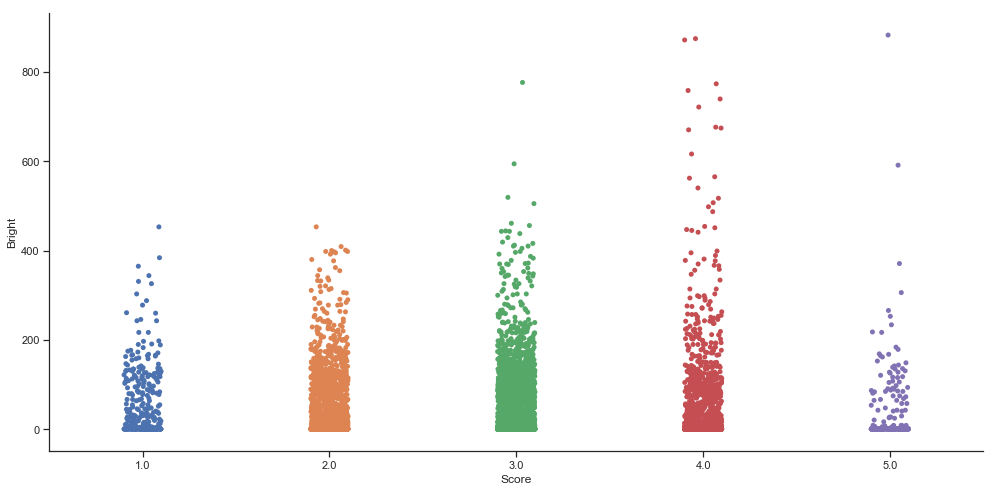

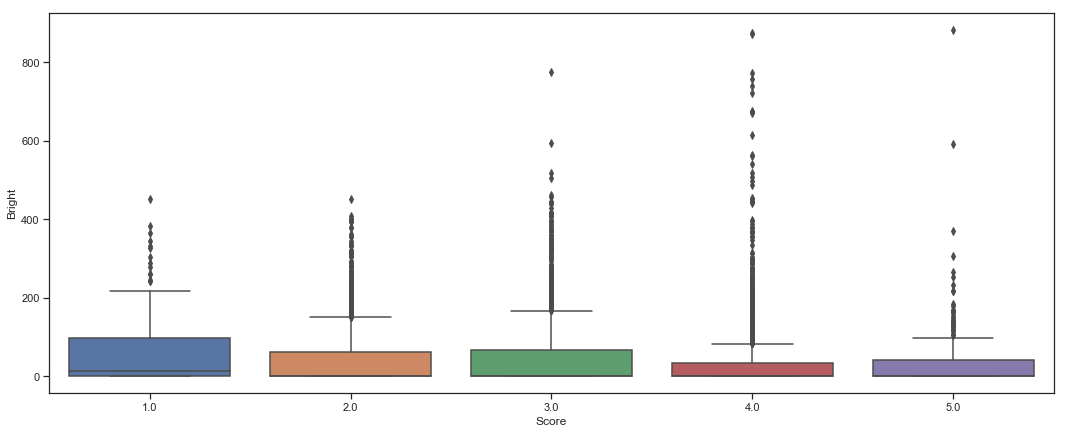

In [20]:
#sns.catplot(x="Score", y="Bright", data=result)
sns.catplot(x="Score", y="Bright", data=result,height=7,aspect=2)
plt.figure(figsize=(18,7))
sns.boxplot(x="Score", y="Bright", data=result)

<b>Observations :</b> <br>
Difficile de prédire le confort ressenti à partir de l'attribut Bright.<br>
75% des valeurs de luminosité de la classe Score=1 sont inférieurs à 96.75, avec une moyenne de 54.63 <br>
75% des valeurs de luminosité de la classe Score=2 sont inférieurs à 61, avec une moyenne de 40.48 <br>
75% des valeurs de luminosité de la classe Score=3 sont inférieurs à 67.75, avec une moyenne de 42.62 <br>
75% des valeurs de luminosité de la classe Score=4 sont inférieurs à 34, avec une moyenne de 39 <br>
75% des valeurs de luminosité de la classe Score=5 sont inférieurs à 41, avec une moyenne de 37.93 <br>

<br>
<b>Décisions :</b> <br>
On ne peut pas encore decider si on prend en considération l'attribut 'CO2' dans l'apprentissage du model ou pas. <br> <br>


### Matrice des nuages de points

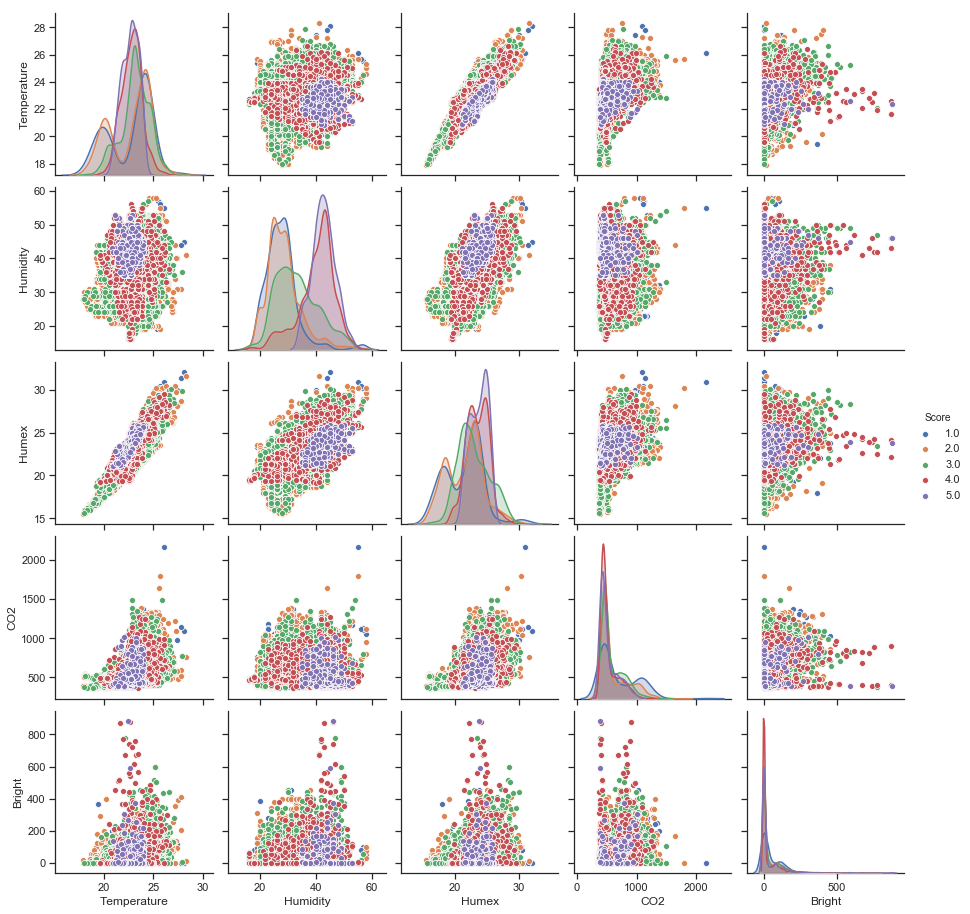

In [21]:
sns.pairplot(result, hue='Score',  vars=["Temperature","Humidity","Humex","CO2","Bright"]);

### Zoom sur la distribution des attributs par rapport aux 5 classes de confort

Pour la distribution des attributs j'utilise la fonction kdeplot fournie par la librairie seaborn.<br>
kde (kernel density estimate) : approximation la distributions des données en utilisant une loi normale. 

In [22]:
def mon_kde(dataset, mon_attribut):
    plt.figure()
    fig = sns.FacetGrid(dataset, hue = 'Score',  aspect = 4)
    fig.map(sns.kdeplot, mon_attribut,shade=True )
    #fig.set(xlim = (dataset[mon_attribut].min()-2, dataset[mon_attribut].max()+5))
    fig.add_legend()


#### Distribution de la temperature

<Figure size 432x288 with 0 Axes>

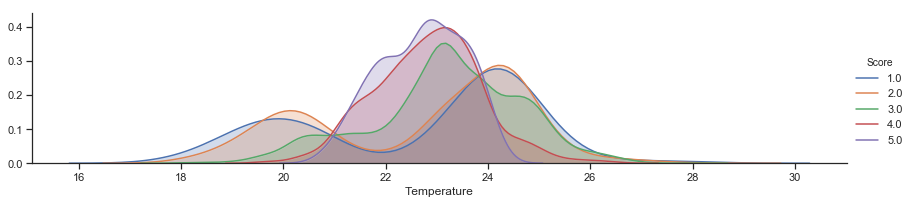

In [23]:
mon_kde(result,'Temperature')

#### Distribution de l'humidité

<Figure size 432x288 with 0 Axes>

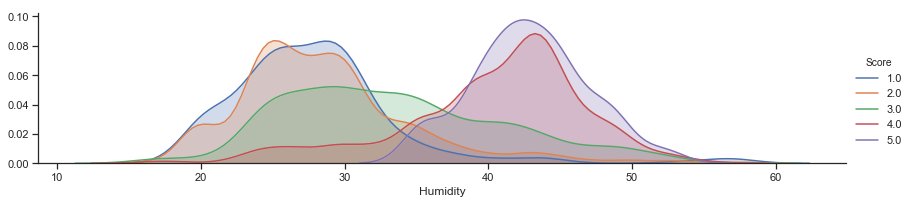

In [24]:
mon_kde(result,'Humidity')

#### Distribution de l'attribut Humex qui caratérise la qualité de l'air

<Figure size 432x288 with 0 Axes>

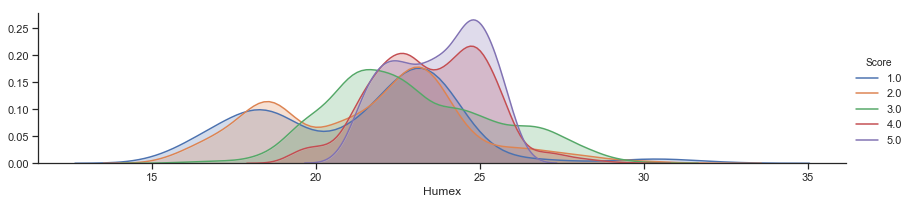

In [25]:
mon_kde(result,'Humex')

#### Distribution du taux de CO2

<Figure size 432x288 with 0 Axes>

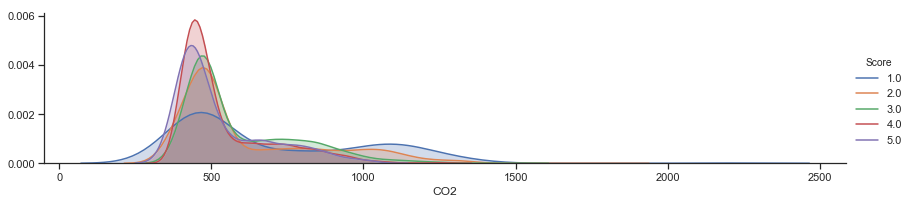

In [26]:
mon_kde(result,'CO2')

#### Distribution de la luminosité

<Figure size 432x288 with 0 Axes>

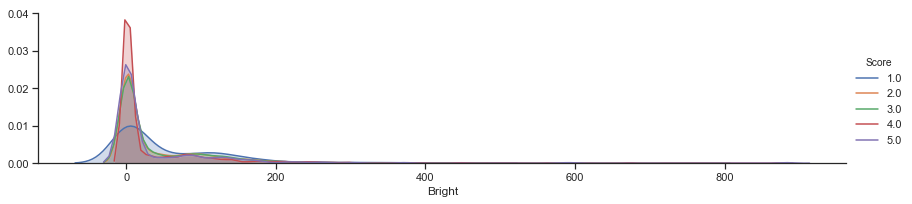

In [27]:
mon_kde(result,'Bright')

<br><br><br><hr>

### Tableau de statistique descriptive bivariée
<br>
Ce tableau résume la distribution des valeurs de chaque attribut par rapport aux 5 classes de confort <br>
 

In [38]:
t=result.copy()
t[['Temperature','Humidity','Humex','CO2','Bright','Score']].groupby(['Score'], as_index=False).describe().T


0            1            2            3  \
Temperature count   358.000000  2181.000000  3362.000000  1860.000000   
            mean     22.694413    22.724484    23.195419    22.831183   
            std       2.234043     2.092292     1.464792     1.036922   
            min      18.000000    17.900000    18.000000    19.600000   
            25%      20.300000    20.500000    22.500000    22.100000   
            50%      23.800000    23.500000    23.300000    22.900000   
            75%      24.300000    24.400000    24.200000    23.500000   
            max      28.100000    28.300000    27.900000    26.600000   
Humidity    count   358.000000  2181.000000  3362.000000  1860.000000   
            mean     27.882682    28.674920    33.462225    40.357527   
            std       5.961847     6.240902     7.599145     6.475893   
            min      18.000000    16.000000    16.000000    16.000000   
            25%      24.000000    25.000000    28.000000    37.000000   
            50%      27.000000    28.000000    33.000000    42.000000   
            75%      30.000000    31.000000    39.000000    44.000000   
            max      58.000000    58.000000    57.000000    56.000000   
Humex       count   358.000000  2181.000000  3362.000000  1860.000000   
            mean     21.432123    21.596653    22.953837    23.512634   
            std       3.010002     2.902249     2.486482     1.715024   
            min      15.600000    15.500000    15.600000    19.100000   
            25%      18.600000    18.900000    21.100000    22.200000   
            50%      22.300000    22.100000    22.600000    23.500000   
            75%      23.400000    23.400000    24.700000    24.800000   
            max      32.100000    31.600000    30.100000    29.600000   
CO2         count   358.000000  2181.000000  3362.000000  1860.000000   
            mean    690.857542   611.840899   590.512790   536.935484   
            std     304.140437   237.439752   183.207595   153.241561   
            min     369.000000   361.000000   367.000000   368.000000   
            25%     465.000000   462.000000   462.000000   435.000000   
            50%     507.000000   495.000000   503.000000   473.000000   
            75%     982.250000   754.000000   709.000000   593.250000   
            max    2168.000000  1791.000000  1494.000000  1273.000000   
Bright      count   358.000000  2181.000000  3362.000000  1860.000000   
            mean     54.634078    40.485099    42.621059    39.008065   
            std      76.886563    68.083209    73.071405    90.058522   
            min       1.000000     1.000000     1.000000     1.000000   
            25%       1.000000     1.000000     1.000000     1.000000   
            50%      14.000000     2.000000     2.000000     1.000000   
            75%      96.750000    61.000000    67.750000    34.000000   
            max     453.000000   453.000000   776.000000   874.000000   
Score       count   358.000000  2181.000000  3362.000000  1860.000000   
            mean      1.000000     2.000000     3.000000     4.000000   
            std       0.000000     0.000000     0.000000     0.000000   
            min       1.000000     2.000000     3.000000     4.000000   
            25%       1.000000     2.000000     3.000000     4.000000   
            50%       1.000000     2.000000     3.000000     4.000000   
            75%       1.000000     2.000000     3.000000     4.000000   
            max       1.000000     2.000000     3.000000     4.000000   

                             4  
Temperature count   239.000000  
            mean     22.707531  
            std       0.819783  
            min      20.800000  
            25%      22.000000  
            50%      22.800000  
            75%      23.400000  
            max      24.200000  
Humidity    count   239.000000  
            mean     42.841004  
            std       4.039697  
            min      35.000000  
            25%      4

<b> Observations : </b><br>
On observe qu'il y a une dependance entre les attributs 'Temperature','Humidity','Humex','CO2' et le confort subjectif ( confort ressenti, attribut Score) <br>
Pour améliorer le confort on doit restreindre l'ensemble de valeurs que peuvent prendre ces attributs. <br>
<b> Décisions : </b><br>
On peut passer à l’étape suivante qui est l'apprentissage du modèle. <br> 
Dans l'apprentissage du modèle on essaye avec l'attribut Bright et sans l'attribut Bright<br>

## Apprentissage du Modele 


<br>

<b>Apprentissage sans l'attribut Bright</b>

In [57]:
x_test = result[["Temperature",'Humidity','Humex','CO2']]
y_test = result[['Score']]
y_test.head()
y_test.shape

(7996, 1)

In [58]:
x_test = x_test.values # 
y_test = y_test.values # 

<br>

In [59]:
"""
fonction qui retourne tableau d'accuracy du classifieur KNN pour des valeurs de k variant de 5 à n 

"""
def get_knn_accuracy(train_x,train_y,loo,n):
    scores = []
    errors = []
    k_neighbors = np.arange(5,n+1) # valeurs de k, de 5 à n
    for k in k_neighbors:
        model = neighbors.KNeighborsClassifier(n_neighbors=k)
        results_loocv = model_selection.cross_val_score(model, train_x, train_y.ravel(),scoring = "accuracy", cv=loo)
        scores.append(results_loocv.mean())
        errors.append(1 - results_loocv.mean())
        

    kppv_scores = pd.DataFrame(
    {
       "K": k_neighbors,
       "Accuracy": scores,
       "Errors": errors
    })
    
    return kppv_scores 
        

In [60]:
loo = LeaveOneOut() ## leave one out cross validation

### Apprentissage avec normalisation des données 

In [61]:
def normaliser(data):
    """ normalisation des données avec la méthode centrer reduire  """
    scaler = StandardScaler()
    scaler.fit(data)
    normal_data=scaler.transform(data)
    return normal_data

normal_data = normaliser(x_test)

In [62]:
accr_normal_data = get_knn_accuracy(normal_data,y_test,loo,28)

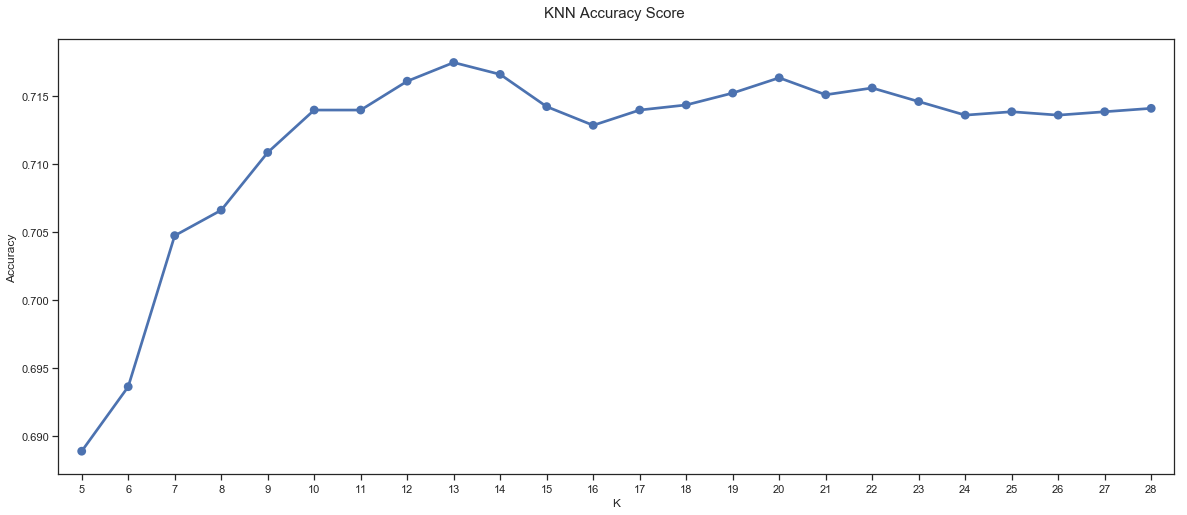

In [52]:
plt.figure(figsize=(20,8))
plt.title('KNN Accuracy Score \n',fontsize='15')
#g = sns.FacetGrid(accr_normal_data,aspect=4)
#g.map(sns.pointplot, "K", "Accuracy",order=np.arange(5,28+1))
sns.pointplot(x="K", y="Accuracy", data=accr_normal_data)


In [53]:
accr_normal_data

,K,Accuracy,Errors
0,5,0.688875,0.311125
1,6,0.693625,0.306375
2,7,0.704750,0.295250
3,8,0.706625,0.293375
4,9,0.710875,0.289125
5,10,0.714000,0.286000
6,11,0.714000,0.286000
7,12,0.716125,0.283875
8,13,0.717500,0.282500
9,14,0.716625,0.283375


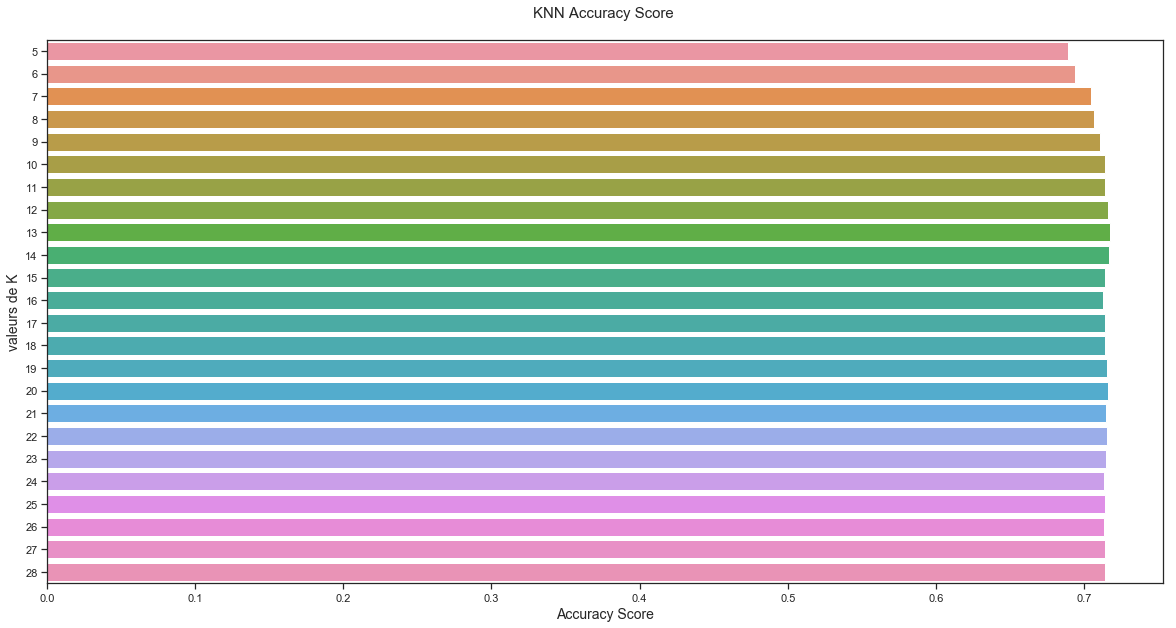

In [54]:
plt.figure(figsize=(20,10))
#g = sns.FacetGrid(res,height=4,aspect=4)
#g.map(sns.barplot, x="Accuracy", y="K",palette="husl");
sns.barplot(x='Accuracy', y = 'K', data = accr_normal_data, orient="h")
plt.title('KNN Accuracy Score \n',fontsize='15')
plt.xlabel('Accuracy Score',fontsize='14')
plt.ylabel('valeurs de K',fontsize='14')
plt.show()

<br>

### Apprentissage sans normalisation des données

In [71]:
accr = get_knn_accuracy(x_test,y_test,loo,28)

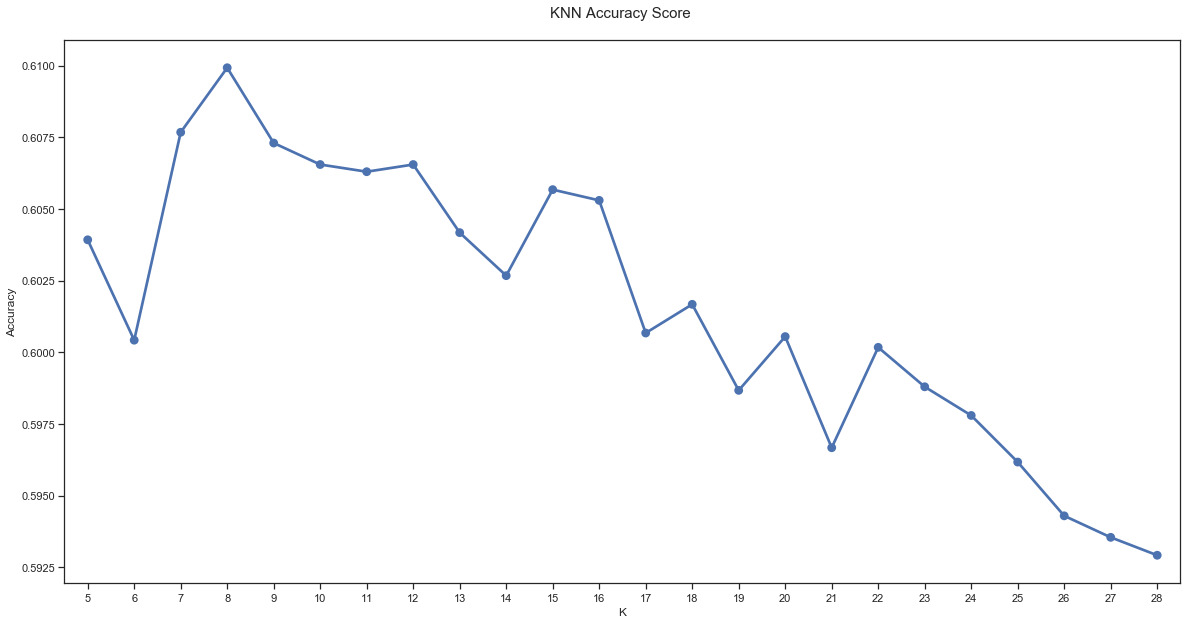

In [72]:
plt.figure(figsize=(20,10))
plt.title('KNN Accuracy Score \n',fontsize='15')
#g = sns.FacetGrid(accr_normal_data,aspect=4)
#g.map(sns.pointplot, "K", "Accuracy",order=np.arange(5,28+1))
sns.pointplot(x="K", y="Accuracy", data=accr)


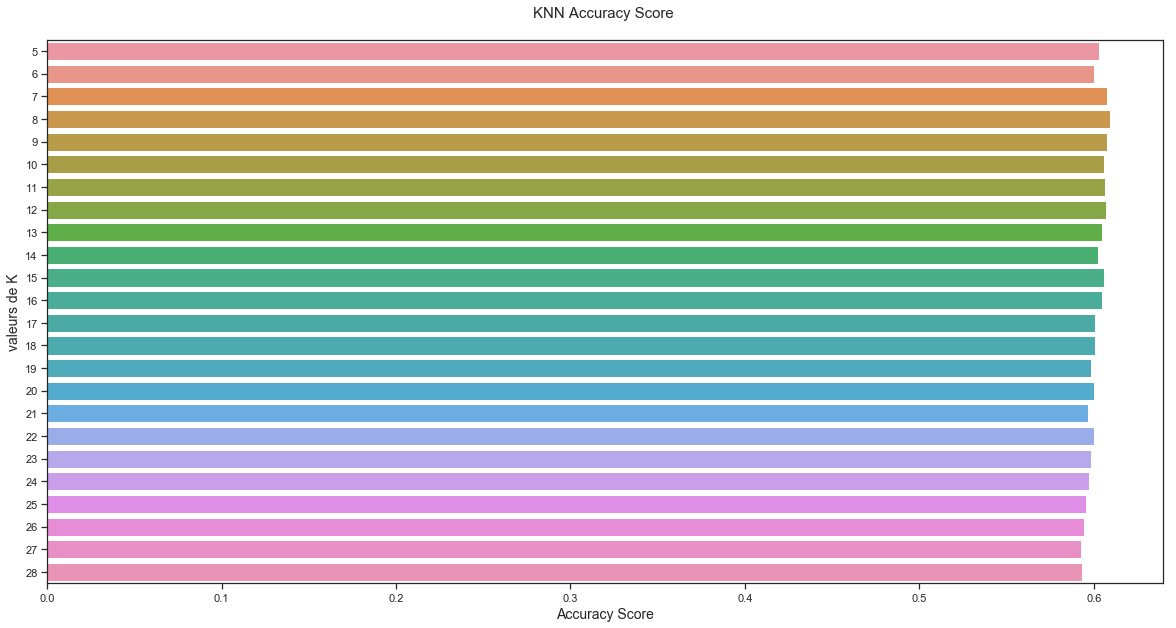

In [30]:
plt.figure(figsize=(20,10))
#g = sns.FacetGrid(res,height=4,aspect=4)
#g.map(sns.barplot, x="Accuracy", y="K",palette="husl");
sns.barplot(x='Accuracy', y = 'K', data = accr, orient="h")
plt.title('KNN Accuracy Score \n',fontsize='15')
plt.xlabel('Accuracy Score',fontsize='14')
plt.ylabel('valeurs de K',fontsize='14')
plt.show()

In [61]:
accr

,K,Accuracy,Errors
0,5,0.603927,0.396073
1,6,0.600425,0.399575
2,7,0.607679,0.392321
3,8,0.609930,0.390070
4,9,0.607304,0.392696
5,10,0.606553,0.393447
6,11,0.606303,0.393697
7,12,0.606553,0.393447
8,13,0.604177,0.395823
9,14,0.602676,0.397324


<br>

### Apprentissage avec l'attribut Bright

#### Apprentissage avec attribut Bright, avec normalisation

In [ ]:
x_train = result[["Temperature",'Humidity','Humex','CO2','Bright']]
x_norm = normaliser(x_train)

In [66]:
accr2 = get_knn_accuracy(x_norm,y_test,loo,28)

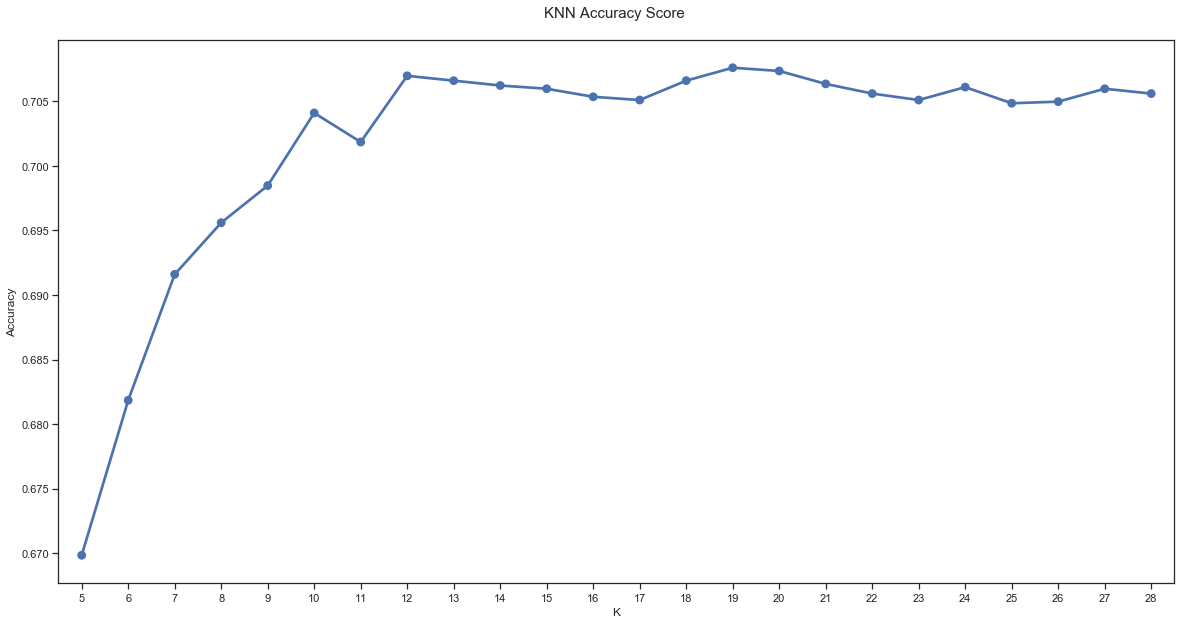

In [68]:
plt.figure(figsize=(20,10))
plt.title('KNN Accuracy Score \n',fontsize='15')
sns.pointplot(x="K", y="Accuracy", data=accr2)

In [73]:
accr2

,K,Accuracy,Errors
0,5,0.669835,0.330165
1,6,0.681841,0.318159
2,7,0.691596,0.308404
3,8,0.695598,0.304402
4,9,0.698474,0.301526
5,10,0.704102,0.295898
6,11,0.701851,0.298149
7,12,0.706978,0.293022
8,13,0.706603,0.293397
9,14,0.706228,0.293772


#### Apprentissage avec attribut Bright, sans normalisation

In [74]:
accr3 = get_knn_accuracy(x_train,y_test,loo,28)

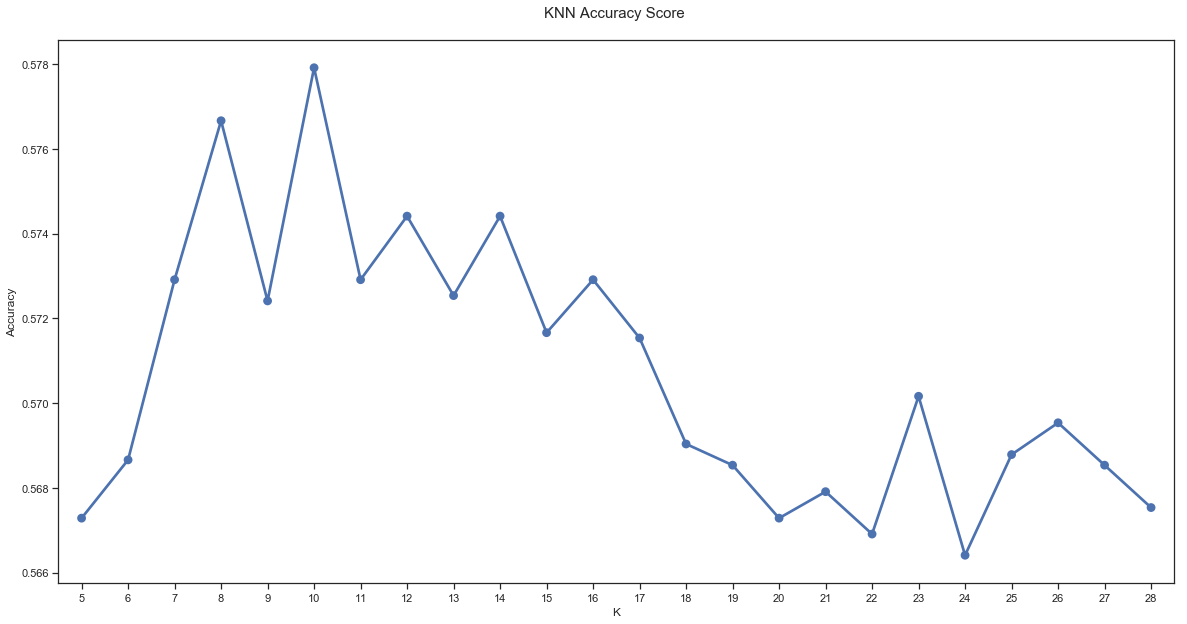

In [82]:
plt.figure(figsize=(20,10))
plt.title('KNN Accuracy Score \n',fontsize='15')
sns.pointplot(x="K", y="Accuracy", data=accr3)

<br><br><br><br>
Pour le classifieur KNN avec K= 13, Les résultats obtenus avec noramlisation des données et sans l'attribut Bright sans les meilleurs.


<br><br><br><b> PS : Pour les matrices de confusion puisque je ne dispose pas de fichier output_test, j'avais decider de ne pas les faire afin de ne pas diminuer la taille de mon fichier d'appretissage </b>